# Анализ жалоб горожан в ЖЭК

## Импорт библиотек

In [16]:
import pandas as pd
import re, string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Формирование набора данных

In [2]:
df = pd.read_csv('Petitions.csv')
df.head()

,id,public_petition_text,reason_category
0,3168490,снег на дороге,Благоустройство
1,3219678,очистить кабельный киоск от рекламы,Благоустройство
2,2963920,"Просим убрать все деревья и кустарники, которы...",Благоустройство
3,3374910,Неудовлетворительное состояние парадной - надп...,Содержание МКД
4,3336285,Граффити,Благоустройство


Информацыия о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59889 entries, 0 to 59888
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    59889 non-null  int64 
 1   public_petition_text  59889 non-null  object
 2   reason_category       59889 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Cтатистические данные

In [5]:
df.describe(include='all')

,id,public_petition_text,reason_category
count,5.988900e+04,59889,59889
unique,NaN,43140,15
top,NaN,снег на дороге,Благоустройство
freq,NaN,700,34769
mean,3.170863e+06,NaN,NaN
std,1.273085e+05,NaN,NaN
min,2.947909e+06,NaN,NaN
25%,3.056146e+06,NaN,NaN
50%,3.172536e+06,NaN,NaN
75%,3.287873e+06,NaN,NaN


Посмотрим на категории и поличество значений в каждой категории

In [8]:
df['reason_category'].value_counts()

reason_category
Благоустройство                                                                     34769
Содержание МКД                                                                      14461
Нарушение правил пользования общим имуществом                                        2170
Незаконная информационная и (или) рекламная конструкция                              1831
Фасад                                                                                1483
Повреждения или неисправность элементов уличной инфраструктуры                       1164
Кровля                                                                                825
Водоснабжение                                                                         809
Состояние рекламных или информационных конструкций                                    673
Санитарное состояние                                                                  434
Центральное отопление                                                               

## Обработка текста

In [9]:
morph = pymorphy3.MorphAnalyzer(lang='ru')
russian_stop_l = set(stopwords.words('russian'))
extra_stop_l = {'в','и','на','gov','spb','ru','gorod','http','problems','не','эта'}
stop_l = russian_stop_l | extra_stop_l

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[0-9A-Za-z" + re.escape(string.punctuation) + r"]+", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def lemmatize(text: str) -> str:
    return " ".join(morph.parse(tok)[0].normal_form for tok in word_tokenize(text))

def remove_stopwords(text: str) -> str:
    return " ".join(tok for tok in text.split() if tok not in stop_l)

df = pd.read_csv('Petitions.csv')
df['processed'] = (
    df['public_petition_text']
      .astype(str)
      .apply(clean_text)
      .apply(lemmatize)
      .apply(remove_stopwords)
)

## Облако слов

Для каждой категории

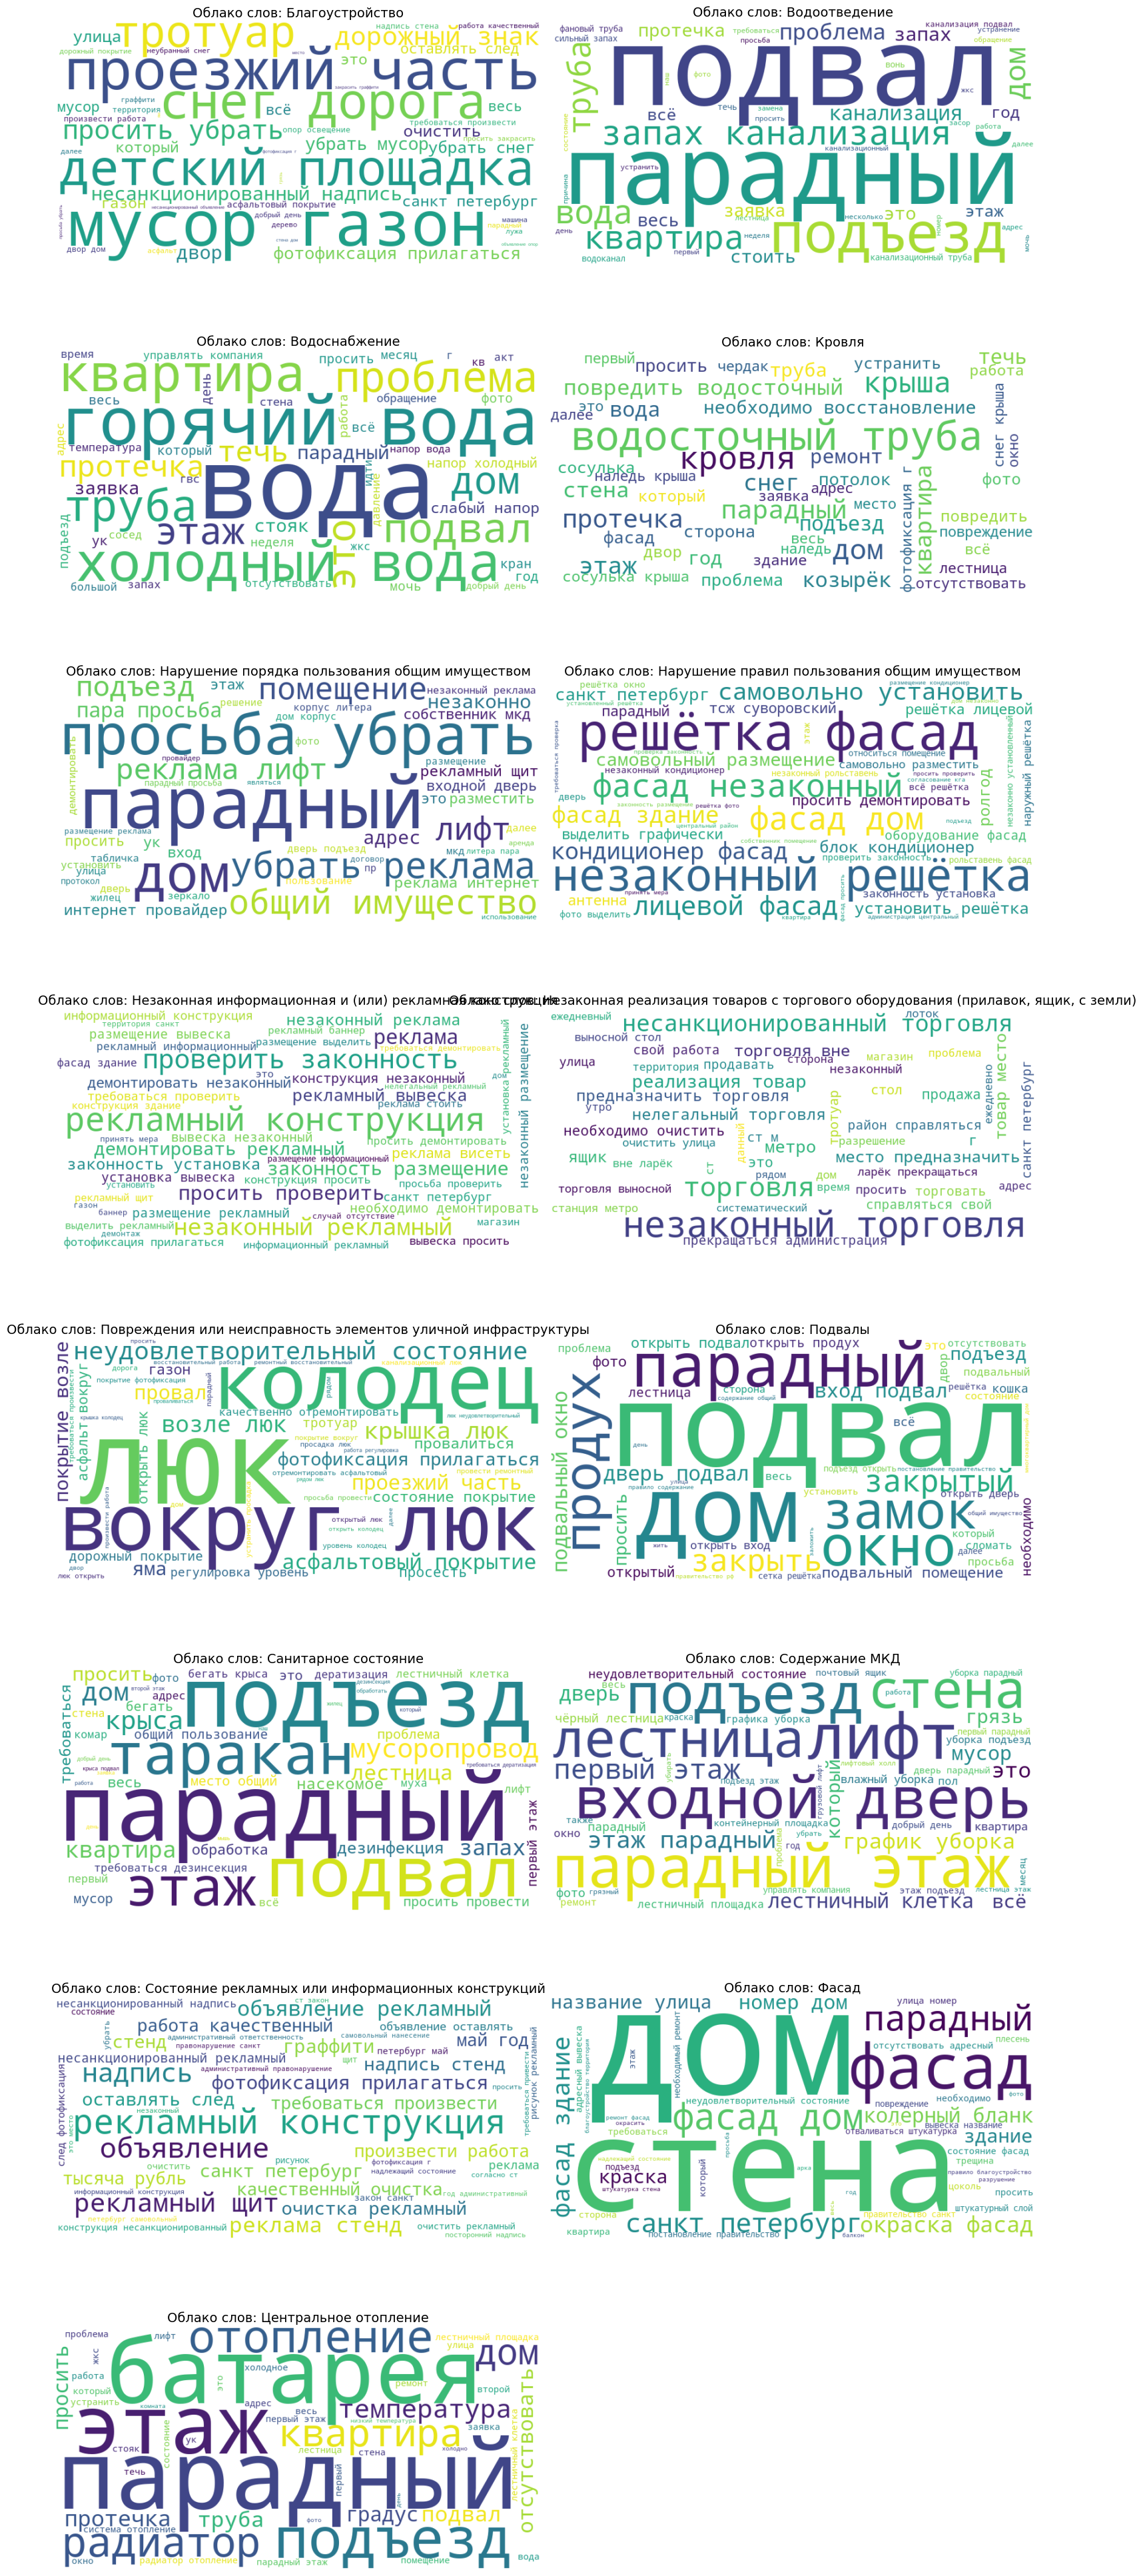

In [19]:
n_categories = len(category_texts)
n_cols = 2
n_rows = (n_categories + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

for i, row in category_texts.iterrows():
    category = row['reason_category']
    text = row['processed']
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=50
    ).generate(text)
    
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов: {category}', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Тематическое моделирование

In [20]:
tfidf = TfidfVectorizer(
    max_df=0.75,
    min_df=0.01,
    max_features=15000,
    ngram_range=(1,7),
    stop_words=list(stop_l)
)
X_tfidf = tfidf.fit_transform(df['processed'])

## Классификация

Кодирование и раделение данных

In [21]:
le = LabelEncoder()
y = le.fit_transform(df['reason_category'].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

In [24]:
model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


C:\Users\Denis\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:06:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                                                                                  precision    recall  f1-score   support

                                                                 Благоустройство       0.88      0.96      0.92     10431
                                                                   Водоотведение       0.46      0.22      0.30        72
                                                                   Водоснабжение       0.76      0.75      0.75       243
                                                                          Кровля       0.62      0.36      0.45       248
                                  Нарушение порядка пользования общим имуществом       0.73      0.45      0.56        73
                                   Нарушение правил пользования общим имуществом       0.87      0.73      0.79       651
                         Незаконная информационная и (или) рекламная конструкция       0.91      0.74      0.82       549
Незаконная реализация т

In [27]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Для разреженных данных используем масштаирование БЕЗ центрирования
scaler = StandardScaler(with_mean=False)  # Отключаем центрирование
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. XGBoost (как было)
model_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)

# 2. Логистическая регрессия с обработкой разреженных данных
model_lr = make_pipeline(
    StandardScaler(with_mean=False),  # Важно для sparse данных
    LogisticRegression(
        multi_class='multinomial',
        solver='saga',  # Лучший выбор для sparse данных
        penalty='l2',
        max_iter=1000,
        random_state=42
    )
)
model_lr.fit(X_train, y_train)

# 3. SGDClassifier с подходящими параметрами
model_sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.001,
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
model_sgd.fit(X_train_scaled, y_train)

# Проверка результатов
models = {'XGBoost': model_xgb, 'LogReg': model_lr, 'SGD': model_sgd}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f'\n{name}:\n{classification_report(y_test, y_pred)}')

C:\Users\Denis\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Denis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     10431
           1       0.46      0.22      0.30        72
           2       0.76      0.75      0.75       243
           3       0.62      0.36      0.45       248
           4       0.73      0.45      0.56        73
           5       0.87      0.73      0.79       651
           6       0.91      0.74      0.82       549
           7       0.72      0.45      0.56        75
           8       0.94      0.69      0.80       349
           9       0.47      0.41      0.44        76
          10       0.68      0.22      0.33       130
          11       0.86      0.86      0.86      4338
          12       0.86      0.38      0.52       202
          13       0.71      0.52      0.60       445
          14       0.15      0.02      0.04        85

    accuracy                           0.87     17967
   macro avg       0.71      0.52      0.58     17967
weighted avg    

C:\Users\Denis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Denis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Denis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Выбираем XGBoost так как он самый точный

Сохраняем для последующего использования

In [9]:
import pickle
import os
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

with open(os.path.join(ARTIFACTS_DIR, "tfidf.pkl"), "wb") as f:
    pickle.dump(tfidf, f)
with open(os.path.join(ARTIFACTS_DIR, "xgb_model.pkl"), "wb") as f:
    pickle.dump(model, f)
with open(os.path.join(ARTIFACTS_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)


Saved tfidf vectorizer
Saved XGB model
Saved label encoder


# Парсинг

In [ ]:
import time
import csv
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def parse_problems(pages=2, pause=1.0, output_csv="problems.csv"):
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--log-level=3")
    driver = webdriver.Chrome(options=chrome_options)

    base_url = "https://gorod.gov.spb.ru"
    list_url_template = base_url + "/problems/public/?page={}"
    results = []

    try:
        for page in range(1, pages + 1):
            print(f"🔍 Обработка страницы {page}")
            driver.get(list_url_template.format(page))

            # Ждём загрузки всех карточек
            WebDriverWait(driver, 10).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "a.problem-tile"))
            )
            tiles = driver.find_elements(By.CSS_SELECTOR, "a.problem-tile")
            links = [tile.get_attribute("href") for tile in tiles]

            for link in links:
                print(f" → {link}")
                driver.get(link)

                try:
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div.masked-text-viewer span"))
                    )
                    text_elem = driver.find_element(By.CSS_SELECTOR, "div.masked-text-viewer span")
                    text = text_elem.text.strip()
                    print(f"{text}")
                    results.append({"url": link, "text": text})
                except:
                    print("Не удалось извлечь текст.")
                time.sleep(pause)
    finally:
        driver.quit()

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["url", "text"])
        writer.writeheader()
        writer.writerows(results)

    print(f"\nСохранено {len(results)} записей в {output_csv}")
    return results

# Запуск
if __name__ == "__main__":
    parse_problems(pages=32, pause=0.5)


# До обучение

Чтение из файла

In [5]:
import pandas as pd
new = pd.read_csv('problems.csv')
new.head()

,url,text
0,https://gorod.gov.spb.ru/problems/6847207/,"Бассейная 27\nГрязь, подмести."
1,https://gorod.gov.spb.ru/problems/6847205/,Отсутствие загона. УК место газона натянул тен...
2,https://gorod.gov.spb.ru/problems/6847203/,Нескошенная трава вокруг дома
3,https://gorod.gov.spb.ru/problems/6847185/,Утрачен информационный знак остановки.
4,https://gorod.gov.spb.ru/problems/6847183/,Сломана дверь в парадную №1 Седова 71


Повторяем преведущие шаги и загружаем модели и размечаем новые данные

In [13]:
import os, re, string, pickle
import pandas as pd
import numpy as np
import pymorphy3
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing        import LabelEncoder
from sklearn.model_selection      import train_test_split
from sklearn.metrics              import classification_report

from imblearn.over_sampling       import RandomOverSampler
from xgboost                      import XGBClassifier
from scipy.sparse                 import hstack, csr_matrix

morph = pymorphy3.MorphAnalyzer(lang='ru')
russian_stop_l = set(stopwords.words('russian'))
extra_stop_l   = {'в','и','на','gov','spb','ru','gorod','http','problems','не','эта'}
stop_l         = russian_stop_l | extra_stop_l

def clean_text(text: str) -> str:
    t = str(text).lower()
    t = re.sub(r"[0-9A-Za-z" + re.escape(string.punctuation) + r"]+", " ", t)
    return re.sub(r"\s+", " ", t).strip()

def lemmatize(text: str) -> str:
    toks = word_tokenize(text)
    return " ".join(morph.parse(tok)[0].normal_form for tok in toks)

def remove_stopwords(text: str) -> str:
    return " ".join(tok for tok in text.split() if tok not in stop_l)

def preprocess_series(series: pd.Series) -> pd.Series:
    return ( series
             .astype(str)
             .apply(clean_text)
             .apply(lemmatize)
             .apply(remove_stopwords)
           )

old_df = pd.read_csv('Petitions.csv')
new_df = pd.read_csv('problems.csv')

old_df['processed'] = preprocess_series(old_df['public_petition_text'])
new_df['processed'] = preprocess_series(new_df['text'])

try:
    with open('tfidf.pkl', 'rb') as f:
        tfidf_old = pickle.load(f)
    with open('xgb_model.pkl', 'rb') as f:
        xgb_old   = pickle.load(f)
    with open('label_encoder.pkl', 'rb') as f:
        le_old    = pickle.load(f)

    X_new = tfidf_old.transform(new_df['processed'])
    preds = xgb_old.predict(X_new)
    new_df['reason_category'] = le_old.inverse_transform(preds)
    print("Новые данные размечены моделью.")
except FileNotFoundError:
    print("Старые артефакты не найдены — разметка новых данных пропущена.")

combined = pd.concat([old_df[['processed','reason_category']], 
                      new_df[['processed','reason_category']]],
                     ignore_index=True)


Новые данные размечены моделью.


Обучение модели с новыми данными

In [16]:
tfidf = TfidfVectorizer(
    max_df=0.75,
    min_df=0.01,
    max_features=15000,
    ngram_range=(1,7),
    stop_words=list(stop_l)
)
X = tfidf.fit_transform(combined['processed'])

le = LabelEncoder()
y  = le.fit_transform(combined['reason_category'].astype(str))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    n_estimators=500,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

with open("tfidf1.pkl", "wb") as f:
    pickle.dump(tfidf, f)
with open("xgb_model1.pkl", "wb") as f:
    pickle.dump(model, f)
with open("label_encoder1.pkl", "wb") as f:
    pickle.dump(le, f)

C:\Users\Denis\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Classification Report ===
                                                                                  precision    recall  f1-score   support

                                                                 Благоустройство       0.89      0.96      0.93      7031
                                                                   Водоотведение       0.52      0.23      0.32        48
                                                                   Водоснабжение       0.73      0.70      0.72       162
                                                                          Кровля       0.65      0.44      0.52       165
                                  Нарушение порядка пользования общим имуществом       0.78      0.51      0.62        49
                                   Нарушение правил пользования общим имуществом       0.86      0.73      0.79       435
                         Незаконная информационная и (или) рекламная конструкция       0.90      0.75      0.82   

# Вывод

Была проведена большая работа, мы обрамотал текст, убрали стоп слова векторизирова текст, обучлил модель и сохранили их.

Запарсиил новые данные с сайта "Наш Санкт-Петербург" 

Обработали новые данные, разметели и добавили их в исходный набор данных и переобучили модели и сохранили их по новой